<a href="https://colab.research.google.com/github/VishwanathDatla/Feature-tracking-and-object-instance-recognition/blob/main/Copy_of_CMSC733_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2:

Name: Vishwanath Datla

UID: 117705928

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here:


In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import pkg_resources
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
%matplotlib inline

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 91.6MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_ima

## Helper Functions

In [ ]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):


    image = Image.open(f'{folder}hotel.seq{i}.png').convert("L")
    image = np.asarray(image).astype('float32')
    arr_images.append(image)
  return arr_images

def trackPoints(xy, imageSequence):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  movedOutFlag = np.zeros(xy.shape[0])

  xyt = []

  for t in range(0, len(imageSequence)-1):
    xy2, movedOutFlag = getNextPoints(imageSequence[t], imageSequence[t+1], xy, movedOutFlag)
    xy = xy2

    for pt in xy2:
      xyt.append(pt)

    if ((t == 0) or (t == 10) or (t == 20) or (t == 30) or (t == 40) or (t == 49)):
      im2color = cv2.cvtColor(imageSequence[t+1], cv2.COLOR_GRAY2BGR)
      corners = np.intp(np.round(xy2))

      for c in range(0, corners.shape[0]):
        if movedOutFlag[c] == False:
          x = corners[c][0]
          y = corners[c][1]
          cv2.circle(im2color, (x, y), DISPLAY_RADIUS, GREEN)
      cv2_imshow(im2color)

  return xyt


folder = '/content/part1_images/'
im = readImages(folder, 51)

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

In [ ]:
def keypoint_detector(input_img, k, window_size, threshold):

    corners = []
    shift = int(window_size/2)
    y_range = input_img.shape[0] - shift
    x_range = input_img.shape[1] - shift

    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    dx = linear_filter(input_img, kernel_x)
    dy = linear_filter(input_img, kernel_y)

    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    for y in range(shift, y_range):
        for x in range(shift, x_range):
            start_y = y - shift
            end_y = y + shift + 1
            start_x = x - shift
            end_x = x + shift + 1
            windowIxx = Ixx[start_y : end_y, start_x : end_x]
            windowIxy = Ixy[start_y : end_y, start_x : end_x]
            windowIyy = Iyy[start_y : end_y, start_x : end_x]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy

            r = det - k*(trace**2)

            if r > threshold:
                corners.append([x, y])
    for i in range(len(corners)):
      for j in range(i+1,len(corners)):
        if((corners[i][0] +5) >= corners[j][0] and (corners[i][0] -5) < corners[j][0] and (corners[i][1] +5) >= corners[j][1] and (corners[i][1] -5) < corners[j][1]):
          corners[j][0] =0
          corners[j][1] =0
    l = len(corners)
    i=0
    while(l):
      if(corners[i][0] == 0):
        corners.pop(i)
      else:
        i=i+1
      l=l-1

    corners = np.asarray(corners)

    return corners



def getKeypoints(img):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold

  output: (N,2) array of [x,y] keypoints
  '''
  # YOUR CODE HERE
  corners = keypoint_detector(img, 0.04, 5, 6000000000)

  # now corners should contain an array of (floating point) pixel locations
  if corners is None:
    print("no keypoints were found!")
    return

  return corners
  # img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#   f_x = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]], np.float32)*0.5
#   f_y = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]], np.float32)*0.5
#   ix = ndimage.convolve(img, f_x)
#   iy = ndimage.convolve(img, f_y)
#   ix2 = np.power(ix,2)
#   iy2 = np.power(iy,2)
#   grad = (ix2+iy2)
#   ix_fil = ndimage.gaussian_filter(ix2,tau)
#   iy_fil = ndimage.gaussian_filter(iy2,tau)
#   grad_fil = ndimage.gaussian_filter(grad,tau)
#   P = np.zeros(img.shape)
#   harris = np.zeros(img.shape)
#   max = 0
#   for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#       M = np.array([[ix_fil[i][j],grad_fil[i][j]],[iy_fil[i][j],grad_fil[i][j]]])
#       # print(M.shape)
#       harris[i][j] = np.linalg.det(M) - tau * (np.power(np.trace(M), 2))
#       if harris[i][j]>max:
#         max = harris[i][j]
#   for i in range(img.shape[0]-1) :
#     for j in range(img.shape[1]-1) :
#         if harris[i][j] > 0.05*max  and harris[i][j] > np.array([harris[i-1][j],harris[i][j-1],harris[i-1][j-1],harris[i+1][j],harris[i][j+1],harris[i+1][j+1],harris[i-1][j+1],harris[i+1][j-1]]).max() :
#             P[i][j] = 1
#   points = np.where(P==1)
#   return np.asarray(points)

# # compute keypoints in the first sequence
# path = '/content/part1_images/hotel.seq0.png'
# # img = np.array(Image.open(path))
# img = Image.open(path).convert("L")
# img = np.asarray(img).astype('float32')
# key_pts = getKeypoints(img)
# plt.plot(key_pts[1], key_pts[0],'go')
# plt.imshow(img, cmap='gray')
# plt.show()
# add plots for the write-up
# YOUR CODE HERE


### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)




1.getKeypoints uses Harris corner detection. The image is first convolved with filters to compute the gradient. The matrix M is computed as [Ix,grad];[Iy,grad].
Determinant- tau*trace^2 is computed for the matrix and the maximum value is computed.
This value if used for the following comparison:
Corners can be found by checking changes in gradient. Edges have a big change in gradient along one axis but corners have a big gradient change along both axes. Using this, most corners of the image are extracted

2.
![Harris corner detecrtion](http://drive.google.com/uc?export=view&id=1-OHDQmtfBLT1N9gIOY4e9m_rQHiN8SQE)

## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence.

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section.



### Code (10 pts)

[163  79]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


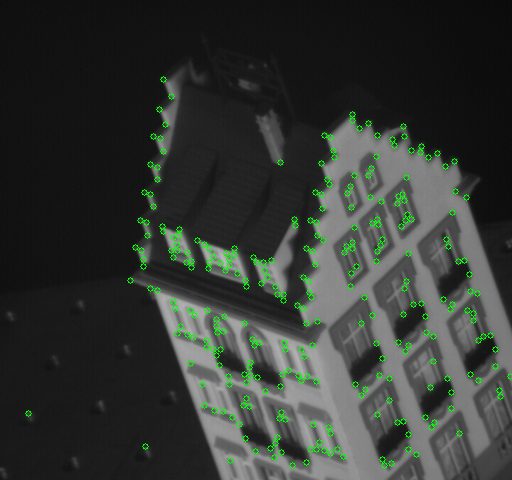

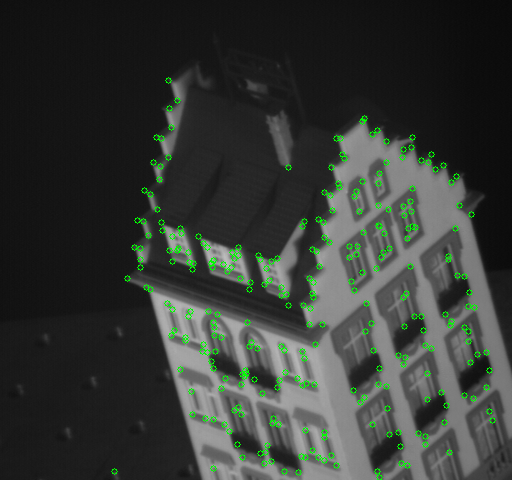

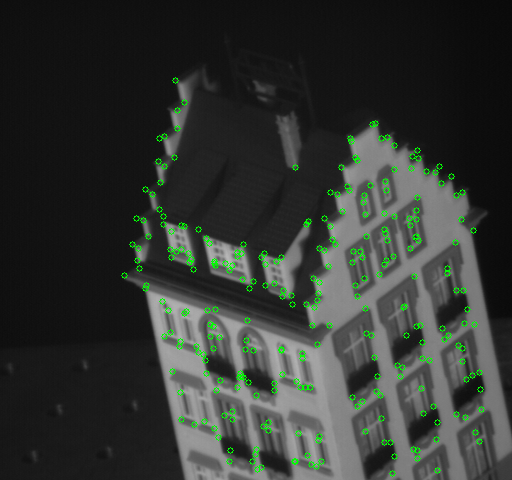

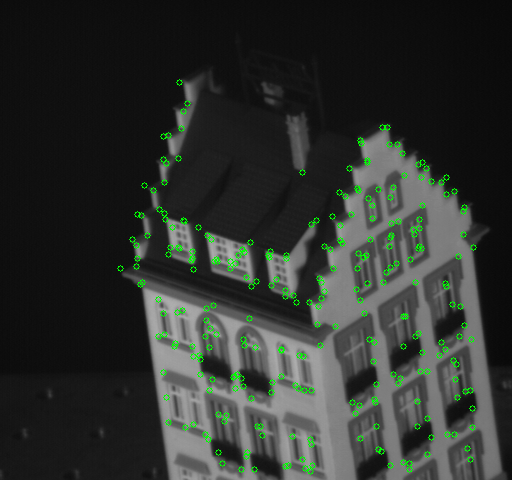

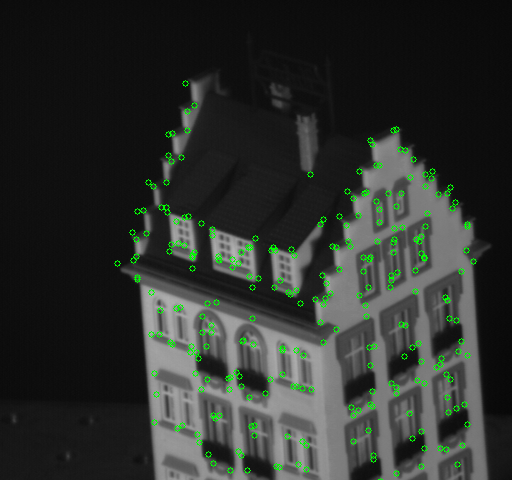

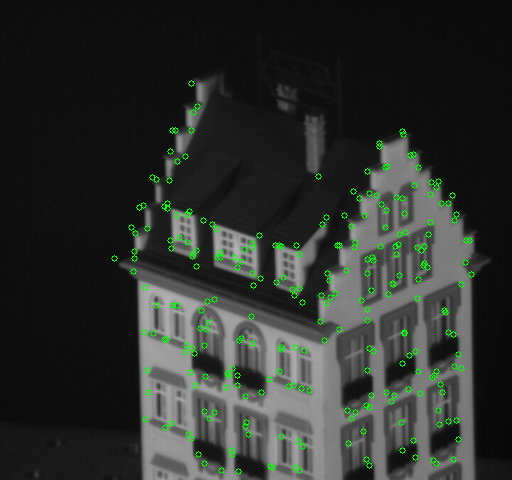

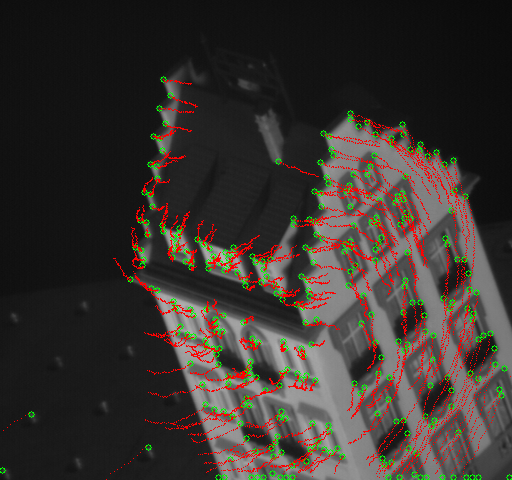

In [ ]:
# def getRectSubPix(img,size,center):
#   patch = np.zeros((size,size))
#   for i in range (0,size):
#     for j in range (0,size):
#       x = int(i+center[0]- (size-1)*0.5)
#       y = int(j+center[1] - (size-1)*0.5)
#       if x>img.shape[0]:
#         x= img.shape[0]-1
#       if y>img.shape[1]:
#         y = img.shape[1]-1
#       patch[i][j] = img[x][y]
#   return patch


def linear_filter(img, kernel):

  img_x, img_y = img.shape
  kernel_x, kernel_y = kernel.shape
  kernel_x = int(np.floor(kernel_x/2))
  kernel_y = int(np.floor(kernel_y/2))

  img_padded = np.pad(img, (kernel_x, kernel_y), 'constant', constant_values=0)
  X, Y = img_padded.shape

  conv_output = np.zeros((img_x, img_y))

  for i in range(kernel_x, X-kernel_x):
      for j in range(kernel_y, Y-kernel_y):
          window = img_padded[i-kernel_x:i+kernel_x+1, j-kernel_y:j+kernel_y+1]
          conv_output[i-kernel_x][j-kernel_y] = np.sum(window*kernel)

  return conv_output


def getNextPoints(im1, im2, xy, movedOutFlag):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  # YOUR CODE HERE
  xy2 = np.copy(xy).astype(float)
  im1 = im1.astype(np.float32)
  im2 = im2.astype(np.float32)
  # Gaussian kernel for smoothing
  kernel = np.array([
          [1, 4, 7, 4, 1],
          [4, 16, 26, 16, 4],
          [7, 26, 41, 26, 7],
          [4, 16, 26, 16, 4],
          [1, 4, 7, 4, 1,]], dtype=np.float32) / 273.0

  img = linear_filter(im1, kernel).astype(np.float32)
  Iy, Ix =  np.gradient(img)
  Ix.astype('int8')

  for i in range(len(xy)):
    patch_x = cv2.getRectSubPix(Ix, (15,15) , (int(xy[i,0]), int(xy[i,1])))

    patch_y = cv2.getRectSubPix(Iy, (15,15), (int(xy[i,0]), int(xy[i,1])))
    A = np.array([[np.sum(patch_x * patch_x), np.sum(patch_x * patch_y)], [np.sum(patch_x * patch_y), np.sum(patch_y * patch_y)]])

    for j in range(25):
      patch_t = cv2.getRectSubPix(im2, (15,15), (int(xy2[i,0]), int(xy2[i,1]))) - cv2.getRectSubPix(img, (15,15), (int(xy[i,0]), int(xy[i,1])))
      B = -1* np.array([[np.sum(patch_x*patch_t)],[np.sum(patch_y*patch_t)]])
      disp = np.matmul(np.linalg.pinv(A), B)

      u = disp[0]
      v = disp[1]

      xy2[i] = [xy2[i,0] + u, xy2[i,1] + v]
      if np.hypot(u, v) <= 0.01:
        break

  if xy2[i,0] >= len(im1) or xy2[i,0] < 0 or xy2[i,1] >= len(im1[0]) or xy2[i,1] < 0:
    movedOutFlag[i] = 1
  return (xy2,movedOutFlag)


NUMBER_OF_IMAGES = 50
DISPLAY_RADIUS = 3
GREEN = (0, 255, 0)
RED = (0, 0, 255)

# plot your results
# YOUR CODE HERE
def drawPaths(im0color, xyt):
  for pt in xyt:
    im0color = cv2.circle(im0color, (round(pt[0]),round(pt[1])), radius=0, color= RED, thickness=1)
  cv2_imshow(im0color)

def mainFunction():

  image0 = im[0]

  xy = getKeypoints(image0)


  image0color = cv2.cvtColor(image0, cv2.COLOR_GRAY2BGR)
  corners = np.intp(np.round(xy))
  print(corners[0])
  for i in corners:
    x, y = i.ravel()
    cv2.circle(image0color, (x, y), DISPLAY_RADIUS, GREEN)

  xyt = trackPoints(xy, im)
  drawPaths(image0color, xyt)
  return

mainFunction()

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





**Include your write-up here**

1. keypoints(Green), tracked keypoints(Red)
![](https://drive.google.com/uc?export=view&id=1x9Y_4elwLdFpk5JclmVVd4V-GAoxuius)

2.20 random keypoints
![](https://drive.google.com/uc?export=view&id=1kTO5p7COnL5aUWVjHmehZhIzJTVaSH0j)

3.Points which moved out
![](https://drive.google.com/uc?export=view&id=1DOq7U0GxdVfWK5eSwWi4eoNVmv55h6RB)

# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 57.6MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

## Helper Functions

In [ ]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x)
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time
     thick: true if a line should be thickened for display
  '''
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim


## Code (15 pts)

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math

def euclidian_distance(a, b):
    return np.sqrt(np.sum((a-b)**2, axis=1))

def kneighbors(B,A, return_distance=True):

        n_neighbors = 1
        dist = []
        neigh_ind = []

        point_dist = [euclidian_distance(b, A) for b in B]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)


def point_based_matching(point_pairs):

    x_mean = 0
    y_mean = 0
    xp_mean = 0
    yp_mean = 0
    n = len(point_pairs)

    if n == 0:
        return None, None, None

    for pair in point_pairs:

        (x, y), (xp, yp) = pair

        x_mean += x
        y_mean += y
        xp_mean += xp
        yp_mean += yp

    x_mean /= n
    y_mean /= n
    xp_mean /= n
    yp_mean /= n

    s_x_xp = 0
    s_y_yp = 0
    s_x_yp = 0
    s_y_xp = 0
    for pair in point_pairs:

        (x, y), (xp, yp) = pair

        s_x_xp += (x - x_mean)*(xp - xp_mean)
        s_y_yp += (y - y_mean)*(yp - yp_mean)
        s_x_yp += (x - x_mean)*(yp - yp_mean)
        s_y_xp += (y - y_mean)*(xp - xp_mean)

    rot_angle = math.atan2(s_x_yp - s_y_xp, s_x_xp + s_y_yp)
    translation_x = xp_mean - (x_mean*math.cos(rot_angle) - y_mean*math.sin(rot_angle))
    translation_y = yp_mean - (x_mean*math.sin(rot_angle) + y_mean*math.cos(rot_angle))

    return rot_angle, translation_x, translation_y


  # YOUR CODE HERE
def align_shape(reference_points, points, max_iterations=50, distance_threshold=0.1, convergence_translation_threshold=1e-3,
        convergence_rotation_threshold=1e-4, point_pairs_threshold=10, verbose=False):

    transformation_history = []

    for iter_num in range(max_iterations):

        closest_point_pairs = []

        distances, indices = kneighbors(reference_points,points)
        for nn_index in range(len(distances)):
            if distances[nn_index][0] < distance_threshold:
                closest_point_pairs.append((points[nn_index], reference_points[indices[nn_index][0]]))

        if len(closest_point_pairs) < point_pairs_threshold:
            break

        closest_rot_angle, closest_translation_x, closest_translation_y = point_based_matching(closest_point_pairs)
        if closest_rot_angle is not None:
            if verbose:
                print('Rotation:', math.degrees(closest_rot_angle), 'degrees')
                print('Translation:', closest_translation_x, closest_translation_y)
        if closest_rot_angle is None or closest_translation_x is None or closest_translation_y is None:
            if verbose:
                print('No better solution can be found!')
            break

        c, s = math.cos(closest_rot_angle), math.sin(closest_rot_angle)
        rot = np.array([[c, -s],
                        [s, c]])
        aligned_points = np.dot(points, rot.T)
        aligned_points[:, 0] += closest_translation_x
        aligned_points[:, 1] += closest_translation_y

        points = aligned_points
        transformation_history.append(np.hstack((rot, np.array([[closest_translation_x], [closest_translation_y]]))))

        if (abs(closest_rot_angle) < convergence_rotation_threshold) \
                and (abs(closest_translation_x) < convergence_translation_threshold) \
                and (abs(closest_translation_y) < convergence_translation_threshold):

            break

    return transformation_history, points



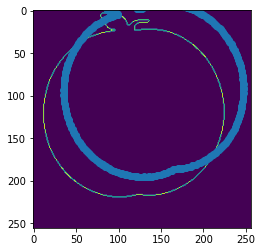

Time taken for alignment 0.18199753761291504


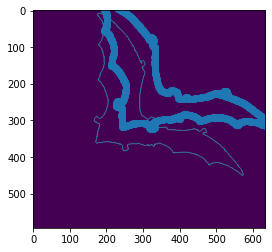

Time taken for alignment 1.2110686302185059


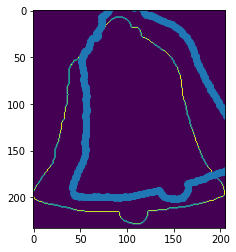

Time taken for alignment 0.12590265274047852


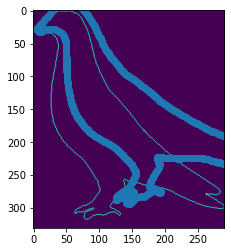

Time taken for alignment 0.4835975170135498


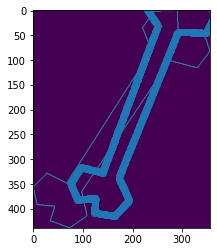

Time taken for alignment 0.517491340637207


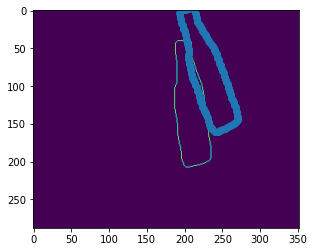

Time taken for alignment 0.05319333076477051


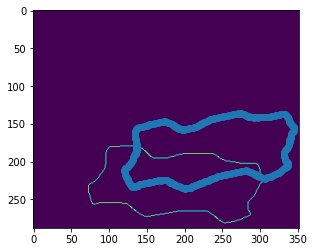

Time taken for alignment 0.11666178703308105


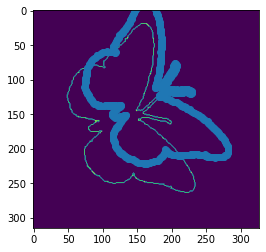

Time taken for alignment 0.4747004508972168


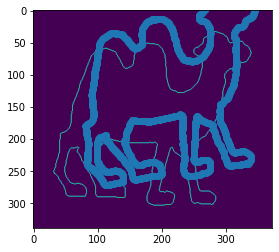

Time taken for alignment 1.0388522148132324


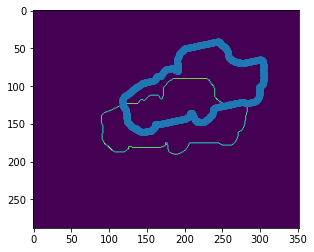

Time taken for alignment 0.09723091125488281


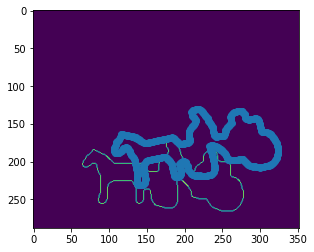

Time taken for alignment 0.23757696151733398


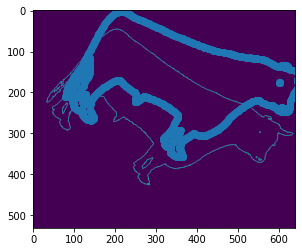

Time taken for alignment 2.936830997467041


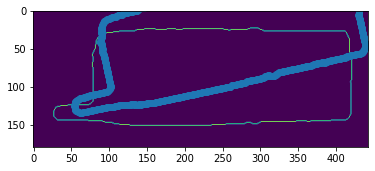

Time taken for alignment 0.3441016674041748


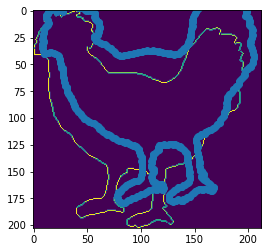

Time taken for alignment 0.26076722145080566


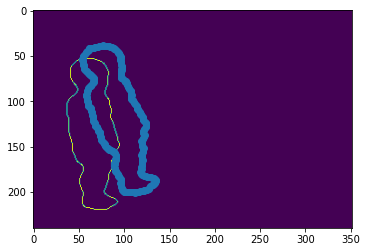

Time taken for alignment 0.0666353702545166


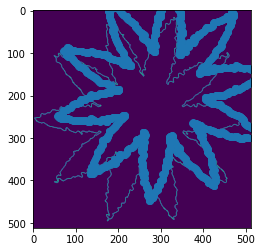

Time taken for alignment 6.855698823928833


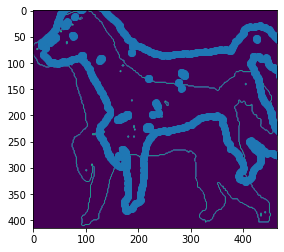

Time taken for alignment 2.369630813598633


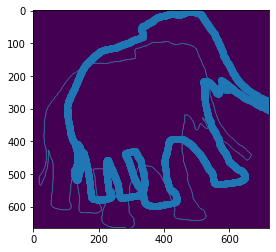

Time taken for alignment 5.071659326553345


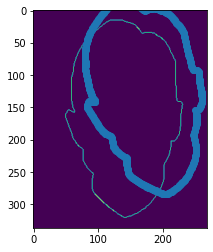

Time taken for alignment 0.22713899612426758


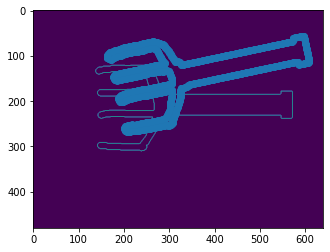

Time taken for alignment 1.3278982639312744


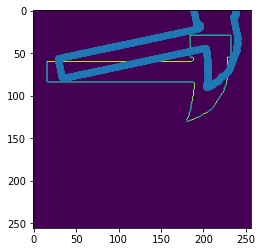

Time taken for alignment 0.1346585750579834


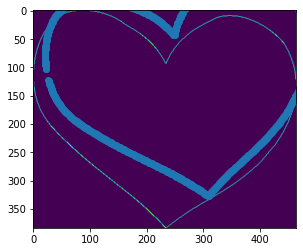

Time taken for alignment 0.665412425994873


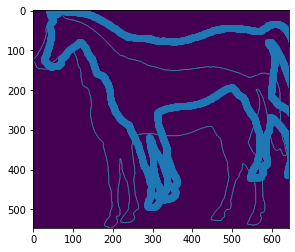

Time taken for alignment 6.97414755821228


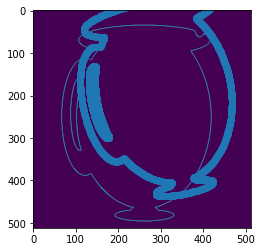

Time taken for alignment 1.4319841861724854


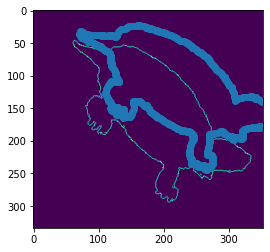

Time taken for alignment 0.40279221534729004


In [ ]:
imgPath = '/content/part2_images/';
import time


objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
    'Heart', 'horse', 'jar', 'turtle']

numObj = len(objList)

# Add code to run align_shape() and display the results and the errors
# YOUR CODE HERE
for i in range(numObj):
  start = time.time()
  path1 = imgPath+objList[i]+'_1.png'
  path2 = imgPath+objList[i]+'_2.png'
  img1 = np.array(Image.open(path1))
  img = Image.open(path2)
  img2 = np.array(img)
  ys,xs = np.where(img1>0)
  xs = xs.reshape((xs.shape[0],1))
  ys = ys.reshape((ys.shape[0],1))
  reference_points = np.hstack((xs, ys))


  yt,xt = np.where(img2>0)
  xt = xt.reshape((xt.shape[0],1))
  yt = yt.reshape((yt.shape[0],1))
  points_to_be_aligned = np.hstack((xt, yt))
  theta = math.radians(12)
  c, s = math.cos(theta), math.sin(theta)
  rot = np.array([[c, -s],
                    [s, c]])
  points_to_be_aligned = np.dot(points_to_be_aligned, rot)

  points_to_be_aligned += np.array([np.random.random_sample(), np.random.random_sample()])

  transformation_history, aligned_points = align_shape(reference_points, points_to_be_aligned, verbose=True)
  x = aligned_points[:,0]
  y = aligned_points[:,1]
  end = time.time()
  plt.scatter(x,y)
  plt.imshow(img2)
  plt.show()
  print('Time taken for alignment',end-start)






## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Include your write-up here**

1. The algorithm used for shape alignment is Iteraticve closest point algorithm. The algorithm is implemented as follows:
(i) Translation and scaling is computed using mean and variance to obtain the initial transform.
(ii) Points are shifted using the transformation matrix
(iii) The nearest neighbors between the shifted points and the reference points(second image)
(iv) After the nearest neighbors are appended, the translation and rotation matrices are computed.
(v) This is repeated until the distance values are lower than the threshold.

Initialization:
The mean of the points gives the center of translation.
The variance of the points gives us the roatation matrix(arctan) and the mean values are used to compute the translation matrix

Model:
Since this is a combination of translation, rotation and scaling it is an affine transformation model.

2. The images are displayed under the code above


# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 23.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 113MB/s]


## Code (10 pts)

In [ ]:
import cv2
import numpy as np
import scipy.io as sio
from scipy.spatial import distance
import matplotlib.pyplot as plt



## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = sio.loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']


img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')
# fig = plt.figure() # parallel display of images
# fig.add_subplot(1,2,1)
# plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
# fig.add_subplot(1,2,2)
# plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)



# YOUR CODE HERE

des1 = np.double(Descriptor1)
des2 = np.double(Descriptor2)
x = des1.shape[1]-1
y = des2.shape[1]-1

nearest = np.ones((des1.shape[1],5))

for i in range (0,x):
    dij_min = np.sqrt(np.sum((des1[:,i]-des2[:,1])**2))
    nearest[i][0] = i
    for j in range (0,y):
        dij = np.sqrt(np.sum((des1[:,i]-des2[:,j])**2))
        if (dij<dij_min):
            nearest[i][2] = nearest[i][1]
            nearest[i][1] = j
            dij_min = dij
    k = int(nearest[i][2])

    distance = np.sqrt(np.sum((des1[:,i]-des2[:,k])**2))
    ratio = np.sqrt(np.sum((des1[:,i]-des2[:,int(nearest[i][1])])**2))/np.sqrt(np.sum((des1[:,i]-des2[:,int(nearest[i][2])])**2))
    nearest[i][3] = distance
    nearest[i][4] = ratio
dist_threshold = 300
nearest1_2 = nearest[nearest[:,3]<dist_threshold,:]
nearest2_2 = nearest1_2[:,0:2]
matches = np.transpose(nearest2_2)

ratio_threshold = 0.8
nearest1_1= nearest[nearest[:,4]<ratio_threshold,:]
nearest2_1=nearest1_1[:,0:2]
matches_1 = np.transpose(nearest2_1)

# print('Distance threshold',matches.shape)
# print('Ratio threshold',matches_1.shape)



## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2

## Display the matched keypoints
# YOUR CODE HERE


Distance threshold (2, 198)
Ratio threshold (2, 129)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio.

(5 pts) Describe the differences of (1) and (2).

**Your answer here**

![](https://drive.google.com/uc?id=1XNfPofQU3gitYEjEcjmCUAybGaWQiDzq)

![](https://drive.google.com/uc?id=1Ms1rm7hAO0owGhQjXd2Biq9LwK_L-jSn)


Top image - Nearest neighbors
Bottom image - Distance ratio

2. The results from distnace ratio thresholding are relatively better because matches are selected only if there is a large difference between the 1st and 2nd closest descriptors. The nearest neighbor thresholding method however can have false postitves.